In [2]:
!pip install duckdb streamlit matplotlib plotly seaborn pandas numpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 731.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.8 MB/s eta 0:00:00


In [1]:
# import libs

import duckdb
import plotly.express as px
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# first create connection (just needed once)
conn = duckdb.connect()

# create table with your data
query = """
CREATE TABLE mytable AS
SELECT
    column00 AS hypothyroid,
    column01 AS age,
    column02 AS sex,
    column03 AS on_thyroxine,
    column05 AS on_antithyroid_medication,
    column06 AS thyroid_surgery,
    column16 AS t3_measured,
    column17 AS t3

FROM read_csv_auto('hypothyroid.data');
"""

# Creates table (executes the previous query)
conn.execute(query)


## selects everything from the table
query = """
select *
from mytable
"""

## executes the query and creates a dataframe from it.
df = conn.sql(query).df()
df


,hypothyroid,age,sex,on_thyroxine,on_antithyroid_medication,thyroid_surgery,t3_measured,t3
0,hypothyroid,72,M,False,False,False,y,0.60
1,hypothyroid,15,F,True,False,False,y,1.70
2,hypothyroid,24,M,False,False,False,y,0.20
3,hypothyroid,24,F,False,False,False,y,0.40
4,hypothyroid,77,M,False,False,False,y,1.20
...,...,...,...,...,...,...,...,...
3158,negative,58,F,False,False,False,y,1.70
3159,negative,29,F,False,False,False,y,1.80
3160,negative,77,M,False,False,False,y,0.60
3161,negative,74,F,False,False,False,y,0.10


<ipython-input-5-efa59b594de5>:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_grouped = df.groupby(['age_group', 'sex', 'thyroid_surgery']).size().reset_index(name='count')


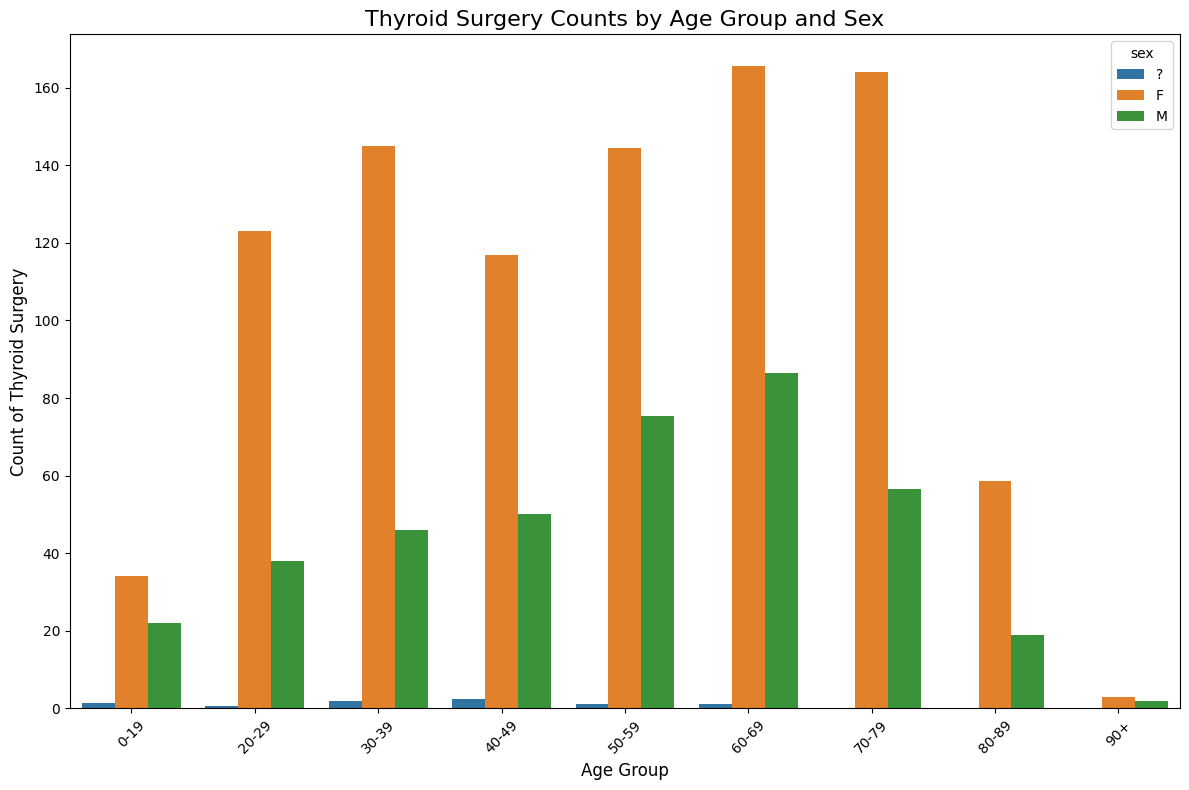

In [5]:
# Convert 'age' to numeric, forcing errors to NaN
df['age'] = pd.to_numeric(df['age'], errors='coerce')


# Create age groups using pd.cut()
# Define age bins and labels
bins = [0, 19, 29, 39, 49, 59, 69, 79, 89, 100]  # Define age bins
labels = ['0-19', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '80-89', '90+']  # Define age group labels
df.loc[:, 'age_group'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)  # right=False makes the intervals left-inclusive
.unt occurrences
df_grouped = df.groupby(['age_group', 'sex', 'thyroid_surgery']).size().reset_index(name='count')

# Set up the figure and axis
plt.figure(figsize=(12, 8))

# Create a barplot using Seaborn with the new 'age_group'
sns.barplot(data=df_grouped, x='age_group', y='count', hue='sex', errorbar=None)

# Set plot labels and title
plt.title('Thyroid Surgery Counts by Age Group and Sex', fontsize=16)
plt.xlabel('Age Group', fontsize=12)
plt.ylabel('Count of Thyroid Surgery', fontsize=12)

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45)

# Display the plot
plt.tight_layout()
plt.show()

It appears thyroid surgery is used as a treatment option more frequently in older individuals, particularly in females compared to males. Based on this data, it also appears thyroid surgery is significantly more common in females compared to males overall without taking age into consideration. This correlates with published evidence that women are more prone to thyroid issues compared to men.

<Axes: xlabel='thyroid_surgery', ylabel='age'>

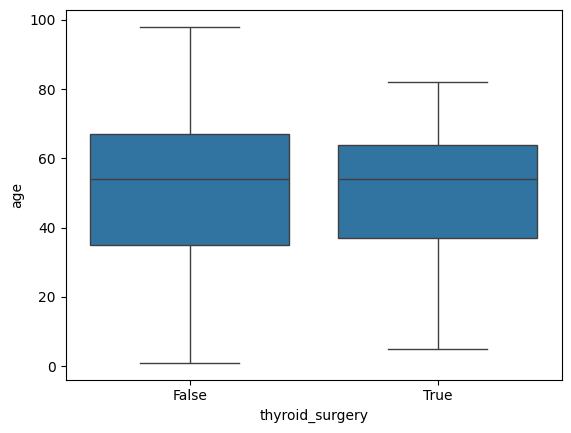

In [6]:
sns.boxplot(data=df, x="thyroid_surgery", y="age")

Based on this boxplot, it appears that thyroid surgery is used as a treatment option more commonly in older individuals as the middle 50% is between ~40 years to ~60 years with a median age for thyroid surgery of ~53-55 years. Surprisingly, thyroid surgery is still performed in much older individuals.

In [7]:
# Create a copy of the original dataframe
df_cleaned = df.copy()


# Ensure 't3' is numeric (if it's not already)
df_cleaned['t3'] = pd.to_numeric(df_cleaned['t3'], errors='coerce')

# Remove NaN values
df_cleaned = df_cleaned.dropna()

# Ensure 'sex' is a categorical type
df_cleaned['sex'] = df_cleaned['sex'].astype('category')

# Create the scatter plot without log scale on the y-axis
fig = px.scatter(
    df_cleaned,
    x="age",
    y="t3",
    color="sex",
    hover_name="sex",
)

# Define custom tick values for the y-axis
tickvals = np.arange(0, 11, 1.0)  # Increments of 0.5

# Update the y-axis with custom tick values
fig.update_yaxes(
    ticks="inside",         # Place ticks inside the axis
    tickformat=".2f",       # Display tick marks with 2 decimal places
    title_text="T3 (pg/mL)",  # Customize y-axis title
    tickmode="array",       # Set custom tick positions
    tickvals=tickvals       # Custom tick values
)

# Display the figure
fig.show()

This interactive scatter plot shows the T3 results based on age and gender. The dataset describes this as "T3 levels" without differentiating between free T3 and bound T3 results.

The normal ranges for free T3 levels are 1.4 - 6.4 picograms per milliliter (pg/mL) based on age according to the Cleveland Clinic (https://my.clevelandclinic.org/health/diagnostics/22425-triiodothyronine-t3). Normal or bound T3 level ranges are 68 - 203 nanograms per deciliter (ng/dL) based on age according to the Cleveland Clinic.

Based on the data, the results appear to be free T3 levels. With that assumption, the majority of data points appear to fall within the normal ranges based on age. It also appears that females receive more frequent free T3 testing compared to males as most data points are color-coded for female.

There are a few extremely high values (> 7 pg/mL). However, most abnormal values are below the normal range based on age, indicating a higher prevalence of hypothyroidism.

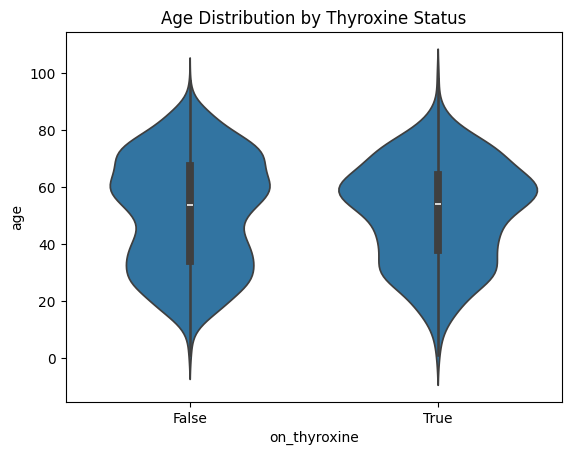

In [8]:
sns.violinplot(x='on_thyroxine', y='age', data=df)
plt.title('Age Distribution by Thyroxine Status')
plt.show()

It appears that thyroxine therapy is started later as distribution begins to increase around 30 years. Distribution gradually increases with a significant peak and the highest distribution observed between 60 and 70 years.